In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from IPython.display import Image 

import math
import random
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf

In [2]:
def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
amb_dis = np.array([[ 4.6 ,  4.63,  4.7 ,  4.55],
       [ 6.05,  6.1 ,  5.64,  5.23],
       [ 8.33,  8.34,  6.97,  6.2 ],
       [10.02,  9.26,  8.69,  8.49]])

for i in range(4):
    poly_dis[i] = np.polyfit(dis_head,amb_dis[i],3)
    
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp + ans).round(2)

In [4]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = np.floor(np.amin(bicubic)), vmax = np.ceil(np.amax(bicubic)))
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)

In [5]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            if nx == 1:
                y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
                y1 = y2-1
                ly = i*(oy-1)/(ny-1) - y1
                interpol[i,j] = garr2[y1,j-1]*(1-ly)+garr2[y2,j-1]*ly
                continue
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'
        garr = read_gtempdata(100,datapath,ln**2)
        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    return interpol


def load_temperature():
    ln = 6
    x_train = np.zeros((4,4,ln**2,100,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        x_train[i] = output_interpolate(temp_path[i],ln).reshape(4,36,100,8,8)
    x_train = x_train.reshape(-1,8,8)
    print("interpolation complete")
    
    temp_arr = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
        
    y_train = np.ones((3,4,4,ln**2))
    
    tdis = np.linspace(1,4,4)
    y_train[1] = (np.ones((4,ln**2,4))*temp_arr).transpose(2,0,1)
    y_train[2] = (np.ones((4,ln**2,4))*tdis).transpose(0,2,1)
    

    for i in range(y_train.shape[1]):
        for j in range(y_train.shape[2]):
            _a = y_train[1,i,j,0]
            _b = tdis[j]
            y_train[0,i,j] = np.ones((36))*(36.5-get_bodytemp(0,_a,_b))
    
    y_train = y_train.transpose(1,2,3,0).reshape(-1,3)
    y_train = (np.ones((100,y_train.shape[0],3))*y_train).transpose(1,0,2).reshape(-1,3)
    print("y_train complete")
    
    x_train2 = np.zeros((x_train.shape[0],2))
    for i in range(x_train.shape[0]):
        bicubic = griddata(points, x_train[i].reshape(-1), (grid_x, grid_y), method='cubic')
        x_train2[i,0] = np.amax(bicubic)
        x_train2[i,1] = np.amin(bicubic)
                        
    return x_train2, y_train

In [6]:
x_train, y_train = load_temperature()

interpolation complete
y_train complete


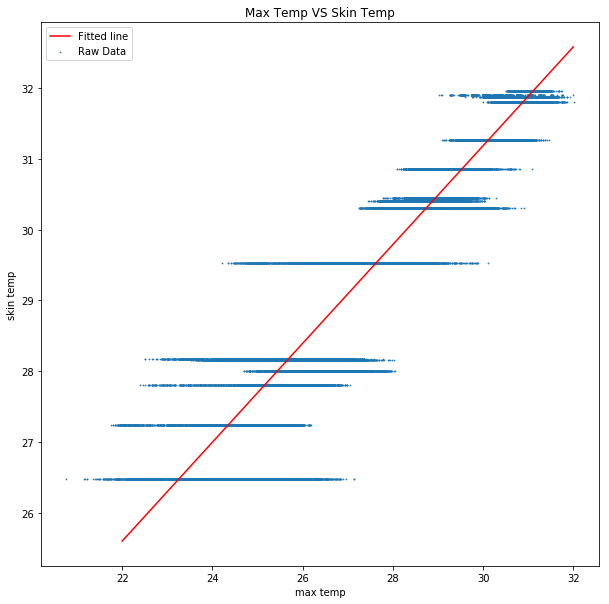

In [11]:
a1, b1, _, _, _ = st.linregress(x_train[:,0], y_train[:,0])
ypoints = np.array([a1*22+b1, a1*32+b1])
xpoints = np.array([22,32])
plt.figure(figsize=(10, 10))
plt.scatter(x_train[:,0], y_train[:,0], label = 'Raw Data', s = 0.5)
plt.plot(xpoints,ypoints,color ='r', label = 'Fitted line')
plt.title('Max Temp VS Skin Temp')
plt.ylabel('skin temp')
plt.xlabel('max temp')
plt.legend()
plt.show()

In [47]:
pearsonr(x_train[:,0], y_train[:,0])

(0.9417648895877805, 0.0)

In [50]:
[a1,b1]

[0.6976074220159528, 10.255522768500377]

In [53]:
l = (a1*x_train[:,0]+b1)-y_train[:,0]

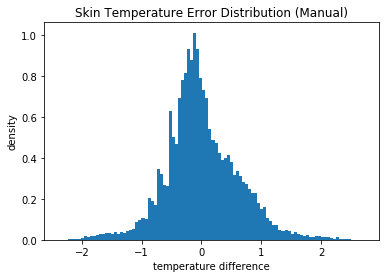

[-1.7072762956457962e-16, -0.06731712084732422, 0.36589149346713645, 0.6048896539594114]
[1.2097793079188228, -1.209779307918823, 1.2097793079188226]


In [85]:
plt.hist(l, bins=100, density = True )
plt.title('Skin Temperature Error Distribution (Manual)')
plt.ylabel('density')
plt.xlabel('temperature difference')
plt.show()
print([np.mean(l),np.median(l),np.var(l),np.std(l)])
print([np.std(l)*2, np.mean(l)-np.std(l)*2, np.mean(l)+np.std(l)*2])

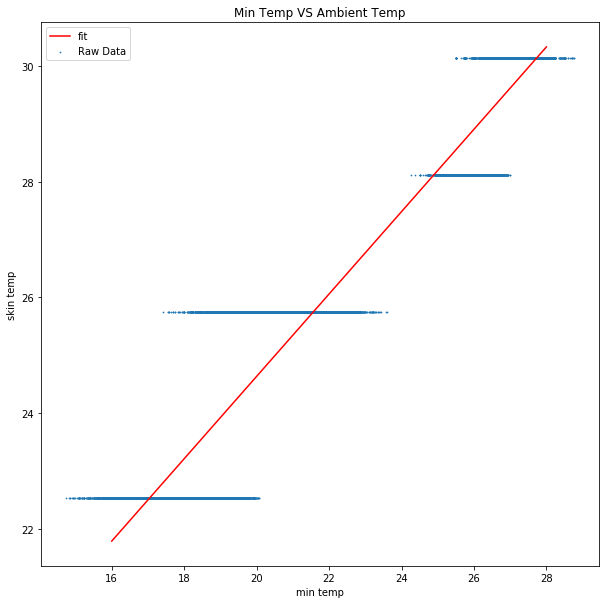

In [12]:
a2, b2, _, _, _ = st.linregress(x_train[:,1], y_train[:,1])
ypoints = np.array([a2*16+b2, a2*28+b2])
xpoints = np.array([16,28])
plt.figure(figsize=(10, 10))
plt.scatter(x_train[:,1], y_train[:,1], label = 'Raw Data', s = 0.5)
plt.plot(xpoints,ypoints,color ='r', label = 'fit')
plt.title('Min Temp VS Ambient Temp')
plt.ylabel('skin temp')
plt.xlabel('min temp')
plt.legend()
plt.show()

In [65]:
pearsonr(x_train[:,1], y_train[:,1])

(0.9658278337625767, 0.0)

In [66]:
[a2,b2]

[0.7117270896846869, 10.39993485394254]

In [67]:
l2 = (a2*x_train[:,1]+b2)-y_train[:,1]

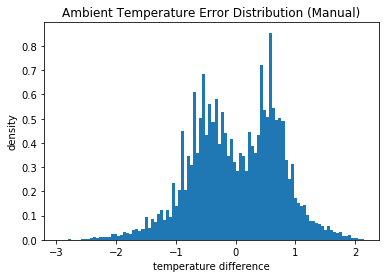

[1.2185807918285719e-14, 0.003444336976098583, 0.5384918828555313, 0.7338200616333211]
[1.4676401232666423, -1.46764012326663, 1.4676401232666545]


In [84]:
plt.hist(l2, bins=100, density = True )
plt.title('Ambient Temperature Error Distribution (Manual)')
plt.ylabel('density')
plt.xlabel('temperature difference')
plt.show()
print([np.mean(l2),np.median(l2),np.var(l2),np.std(l2)])
print([np.std(l2)*2, np.mean(l2)-np.std(l2)*2, np.mean(l2)+np.std(l2)*2])

In [75]:
res = np.array((a1*x_train[:,0]+b1,a2*x_train[:,1]+b2))
l3 =[]
for i in range(x_train.shape[0]):
    l3.append(get_bodytemp(res[0,i],res[1,i],y_train[i,2])-36.5)

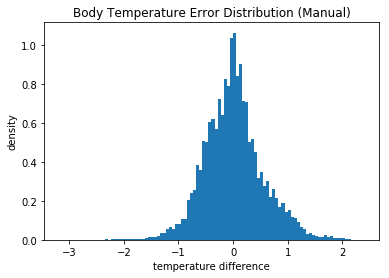

[0.010640798611111111, -0.00999999999999801, 0.29095254250214, 0.5394001691714047]
[1.0788003383428093, -1.0681595397316983, 1.0894411369539203]


In [83]:
plt.hist(l3, bins=100, density = True )
plt.title('Body Temperature Error Distribution (Manual)')
plt.ylabel('density')
plt.xlabel('temperature difference')
plt.show()
print([np.mean(l3),np.median(l3),np.var(l3),np.std(l3)])
print([np.std(l3)*2, np.mean(l3)-np.std(l3)*2, np.mean(l3)+np.std(l3)*2])